In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
#import _pickle as pickle
import pickle
import re, sys, unidecode
#import unidecode

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil
import os

# Representation
import nltk
from nltk.corpus import stopwords
import scikitplot as skplt

import wordbatch
from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL

from tensorflow.contrib.learn import DNNClassifier

#from tecnosmartlib import DataObject

#plt.style.use('fivethirtyeight')

#Carga stop word
nltk.download('stopwords')
spanish_stopwords = nltk.corpus.stopwords.words('spanish')

# punkt:  módulo contiene modelos para la tokenización de textos
nltk.download('punkt')

/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so | _pywrap_tensorflow_internal
/root/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/lite/toco/python/_tensorflow_wrap_toco.so | _tensorflow_wrap_toco
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Parameters

In [2]:
root_path = "../"
path_data_clean = root_path + "data/clean/"
path_model = root_path + 'models/'
features_path = root_path + 'data/features/'
model_name = "test"
path_model += model_name

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

In [3]:
dfNoticias = pd.read_pickle(path_data_clean + "/dfNoticiasClean.p")


In [4]:
dfNoticias.head()

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
1,\nMarcel Granollers (44°) sorprendió a David F...,20140929,09:57,20140929095927,\nEl español cayó ante su compatriota Marcel G...,deportes,None,None,torneos atp,None,None,tenis,None,None,\nDavid Ferrer sufrió otra temprana eliminación\n,fid_noticia
2,\nEl Gobierno de Barack Obama ha enviado cuatr...,20140929,07:03,20140929065051,\nLas conversaciones comenzaron el año 2010 y ...,pais,mundo,mundo,eeuu,relaciones exteriores,None,relaciones exteriores,eeuu,cuba,\nObama ha enviado cuatro solicitudes a Chile ...,fid_noticia
3,\nEste miércoles la Comisión Asesora Presidenc...,20140929,11:37,20140929105234,\nRepresentantes del sector privado acusaron q...,pais,None,None,isapre,None,None,salud,None,None,\nQuiebre en comisión presidencial de isapres ...,fid_noticia
4,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929100825,\nEl pedalero del equipo Avanti terminó en el ...,deportes,None,None,chilenos,None,None,ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia
6,"\nEl Gobierno, a través de Sernapesca, present...",20140929,15:47,20140929152501,\nBachelet instruyó a los ministros de Economí...,pais,pais,None,None,None,None,medioambiente,region de valparaiso,None,\nGobierno presentó querella por derrame de pe...,fid_noticia


# pre procesing



In [5]:
_map = {}
_map["Cuerpo"] = []
_map["Seccion"] = []
_map["Subtema"] = []

count = 0
for index, row in dfNoticias.iterrows():    
    _map["Cuerpo"].append(row["Cuerpo"]) 
    _map["Seccion"].append(row["Seccion_1"])
    _map["Subtema"].append(row["Subtema_1"])

df = pd.DataFrame(_map)
# Elimino clase corporativo, muy pocos ejemplos
df = df[df.Seccion != "corporativo"]

    
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y_untransformed = df['Seccion'].reset_index(drop=True)


# Feature Extraccion

### Data representation
* Normalisacion
* TFID calculation

In [6]:
from nltk.stem.snowball import SnowballStemmer



def normalize_text(text):
    """ Funcion de normalizacion """    
    # split into words
    tokens = nltk.tokenize.word_tokenize(text,language='spanish', preserve_line=False)
    # convert to lower case
    tokens = [w.lower() for w in tokens]    
    
    # remove punctuation from each word
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # remove remaining tokens that are n<<<<<<<<<<<<<<<<<<<<<
    words = [word for word in stripped if word.isalpha()]
    
    # stop word and remove accent
    def strip_accents(s):
        return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    stop_words = set(spanish_stopwords)
    words = [strip_accents(w) for w in words if not w in stop_words]
    
    stemmer = SnowballStemmer("spanish")
    out = ""
    for word in words:
        out += stemmer.stem(word)+" "
    
    return out
    
   return u" ".join(words)

# spanish_stopwords = stopwords.words('spanish')
# def normalize_text(text):
#     return u" ".join([x for x in [y for y in text.lower().strip().split(" ")] 
#                       if len(x) > 1 and x not in spanish_stopwords])

In [7]:
# true calcula features, false carga si ya estan calculadas
calc_tfid = True

features_path = features_path + "tfid_hash28_n1000.p"

if calc_tfid :
    start = time.time()
    print("start")


    X_untransformed = X_untransformed
    n_docs = X_untransformed.shape[0]
    n_cpu = 20

    batch_size = int(n_docs/n_cpu)

    #'log', "idf":50.0
    wb = wordbatch.WordBatch(normalize_text, 
                             extractor=(WordBag, {"hash_ngrams": 1, "hash_ngrams_weights": [1.0, 1.0],
                                                  "hash_size": 2**28, "norm": "l2", "tf": 1.0,
                                                  "idf": 1.0}), procs=n_cpu, n_words=1000, minibatch_size=batch_size)
    
    wb.dictionary_freeze = True
    word_comment = wb.fit_transform(list(X_untransformed),reset= False)
    # revisar esta normalizacion
    X_transformed = word_comment[:, np.array(np.clip(word_comment.getnnz(axis=0) - 1, 0, 1), dtype = bool)]

    end = time.time()
    print("TFIDF end time :" + str(end - start) )


    X = X_transformed


    #X = X.todense()
    print('Number of features: {}'.format(X.shape[1]))

    pickle.dump( X, open( features_path, "wb" ) )
else:    
    X = pickle.load( open( features_path, "rb" ) )

start
Normalize text
Extract wordbags
TFIDF end time :99.53927803039551
Number of features: 1000


### Output

In [8]:
y = y_untransformed.values

np.random.seed(42)

train_fraction = 0.8

train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]



In [9]:
labels = list(set(y))
nClasses = len(labels)

# sizes = {label: y_train[y_train == label].shape[0] for label in labels}
# # pesos calculados segun formula sklearn
# weights = np.asarray([len(y_train)/(sizes[label]*nClasses) for label in y])

scale_factor = 10e3
sizes = {label: y_train[y_train == label].shape[0] for label in labels}
weights = np.asarray([scale_factor/sizes[label] for label in y])


weights = weights[:,np.newaxis]
weights_train = weights[train_indices]
weights_test = weights[test_indices]


# Model

### DNN graph generation

In [10]:
epochs = 14000

# Define the test inputs
def get_train_inputs():    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train.todense(),'class_weights': weights_train},
                                                  y_train[:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=500,
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs():
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test.todense(),'class_weights': weights_test},
                                                  y_test[:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [11]:



feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=1000)]

optimizer = tf.train.ProximalAdagradOptimizer(
                              learning_rate=0.1,
                              l1_regularization_strength= 0#0.0001
                              )

classifier = DNNClassifier(                                
                           n_classes=len(labels), label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[2000, 1000, 100],
                           dropout=0.5,
                           #optimizer = optimizer,
                           weight_column_name='class_weights',
                           model_dir = path_model,
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                           save_checkpoints_secs = None)                           
                          )

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5d389ae278>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../models/test'}


# Training



In [12]:
tf.set_random_seed(42)

    
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    #input_fn= get_train_inputs(),
    input_fn= get_test_inputs(),
    
    every_n_steps=500,
    #early_stopping_metric="accuracy",#loss
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=3000)

start = time.time()
print("start")

#classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)
classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

end = time.time()
print("Training time :" + str(end - start) )


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
start
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ../models/test/model.ckpt.
INFO:tensorflow:loss = 0.8776578, step = 1
INFO:tensorflow:global_step/sec: 23.3778
INFO:tensorflow:loss = 0.83596104, step = 101 (4.280 sec)
INFO:tensorflow:global_step/sec: 23.8311
INFO:tensorflow:loss = 0.90304655, step = 201 (4.195 sec)
INFO:tensorflow:global_step/sec: 24.017
INFO:tensorflow:loss = 0.77962, step = 301 (4.164 sec)
INFO:tensorflow:global_step/sec: 23.7321
INFO:tensorflow:loss = 0.786768, step = 401 (4.214 sec)
INFO:tensorflow:Starting evaluation at 2018-09-14-12:34:19
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-1
INFO:tensorflow:Finished evaluation at 2018-09-14-12:34:23
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.12724143, global_step = 1, loss = 2.0794194
INFO:tensorflow:Validation (step 500): loss = 2.0794194, accurac

INFO:tensorflow:loss = 0.26569003, step = 4001 (9.184 sec)
INFO:tensorflow:global_step/sec: 23.9713
INFO:tensorflow:loss = 0.39375255, step = 4101 (4.172 sec)
INFO:tensorflow:global_step/sec: 23.9435
INFO:tensorflow:loss = 0.34615472, step = 4201 (4.176 sec)
INFO:tensorflow:global_step/sec: 23.1036
INFO:tensorflow:loss = 0.356107, step = 4301 (4.328 sec)
INFO:tensorflow:global_step/sec: 23.9554
INFO:tensorflow:loss = 0.2944446, step = 4401 (4.176 sec)
INFO:tensorflow:Starting evaluation at 2018-09-14-12:37:48
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-4001
INFO:tensorflow:Finished evaluation at 2018-09-14-12:37:53
INFO:tensorflow:Saving dict for global step 4001: accuracy = 0.7599334, global_step = 4001, loss = 0.70538545
INFO:tensorflow:Validation (step 4500): loss = 0.70538545, accuracy = 0.7599334, global_step = 4001
INFO:tensorflow:Saving checkpoints for 4501 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 10.5227
INFO:tensorflow:loss = 0.3

INFO:tensorflow:Starting evaluation at 2018-09-14-12:41:16
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-8001
INFO:tensorflow:Finished evaluation at 2018-09-14-12:41:20
INFO:tensorflow:Saving dict for global step 8001: accuracy = 0.77341586, global_step = 8001, loss = 0.6783315
INFO:tensorflow:Validation (step 8500): loss = 0.6783315, accuracy = 0.77341586, global_step = 8001
INFO:tensorflow:Saving checkpoints for 8501 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 11.6507
INFO:tensorflow:loss = 0.29889715, step = 8501 (8.583 sec)
INFO:tensorflow:global_step/sec: 23.2587
INFO:tensorflow:loss = 0.28373128, step = 8601 (4.298 sec)
INFO:tensorflow:global_step/sec: 23.3225
INFO:tensorflow:loss = 0.25784686, step = 8701 (4.289 sec)
INFO:tensorflow:global_step/sec: 23.6792
INFO:tensorflow:loss = 0.26790845, step = 8801 (4.223 sec)
INFO:tensorflow:global_step/sec: 23.6034
INFO:tensorflow:loss = 0.27919117, step = 8901 (4.238 sec)
INFO:tensorflow:Startin

# Evaluation performance


INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-11500


/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


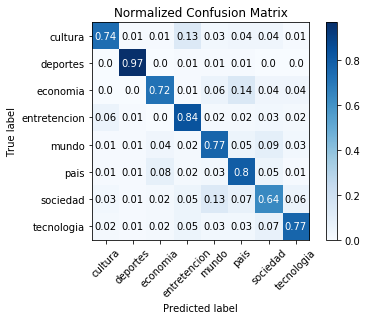

## Accuracy in test: 84.33548279038607 

In [13]:
def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test.todense())}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))